# <ins>Evaluation of Generator Reactive Power Capability Characteristics in Load Flow Analysis</ins>

By incorporating the reactive power capability characteristics of a generator, the minimum **(Qmin)** and maximum **(Qmax)** reactive power limits can be determined as a function of the generator’s active power output. This directly influences the load flow result, which will be demonstrated in subsequent sections of this tutorial.

The **q_capability_curve_table** provides a structured representation of the generator’s reactive power limits and consists of the following key variables:
  * **id_q_capability_curve** – Identifier for the reactive power capability curve in the **q_capability_curve_table**.  <br>
  * **min_q_mvar** – Minimum reactive power limit (Qmin). <br>
  * **max_q_mvar** – Maximum reactive power limit (Qmax). <br>

To facilitate the integration of these limits, the function **create_q_capability_characteristics_object** is employed. This function transforms the provided reactive power curve data into a characteristic object, applying linear interpolation to construct a continuous function. The resulting characteristic is stored in the **q_capability_characteristic** data structure.

Following this, a diagnostic function is executed to identify and report any inconsistencies within the dataset, ensuring data integrity.

In [1]:
import pandas as pd
import numpy as np
import pandapower as pp
from pandapower.control.util.auxiliary import create_q_capability_characteristics_object
from pandapower.control.util.diagnostic import q_capability_curve_table_diagnostic

In [2]:
# Create network
def test_net_for_q_capability_curve(characteristics_data=False):
    net = pp.create_empty_network()
    bus1 = pp.create_bus(
        net, name="bus1", vn_kv=20.0, type="b", min_vm_pu=0.0, max_vm_pu=1.05
    )
    bus2 = pp.create_bus(
        net, name="bus2", vn_kv=110.0, type="b", min_vm_pu=0.0, max_vm_pu=1.05
    )
    bus3 = pp.create_bus(
        net, name="bus3", vn_kv=110.0, type="b", min_vm_pu=0.0, max_vm_pu=1.05
    )

    pp.create_ext_grid(
        net,
        bus3,
        name="External Grid",
        vm_pu=1.0,
        va_degree=0.0,
        max_p_mw=100000,
        min_p_mw=0,
        min_q_mvar=-300,
        max_q_mvar=300,
        s_sc_max_mva=10000,
        s_sc_min_mva=8000,
        rx_max=0.1,
        rx_min=0.1,
    )
    # create lines
    pp.create_line_from_parameters(
        net,
        bus2,
        bus3,
        length_km=10,
        df=1,
        max_loading_percent=100,
        vn_kv=110,
        max_i_ka=0.74,
        type="ol",
        r_ohm_per_km=0.0949,
        x_ohm_per_km=0.38,
        c_nf_per_km=0.0092,
        name="Line",
    )
    # create load
    pp.create_load(net, bus3, p_mw=200, q_mvar=180, name="Load", vm_pu=1.0)

    # create transformer
    pp.create_transformer_from_parameters(
        net,
        bus2,
        bus1,
        name="110kV/20kV transformer",
        parallel=1,
        max_loading_percent=100,
        sn_mva=210,
        vn_hv_kv=110,
        vn_lv_kv=20,
        vk_percent=12.5,
        vkr_percent=0.01904762,
        vk0_percent=10,
        vkr0_percent=0,
        shift_degree=330,
        vector_group="YNd11",
        i0_percent=0.26,
        pfe_kw=0,
        si0_hv_partial=0.5,
    )

    pp.create_gen(
        net,
        bus1,
        p_mw=100,
        sn_mva=255.0,
        scaling=1.0,
        type="Hydro",
        cos_phi=0.8,
        pg_percent=0.0,
        vn_kv=19.0,
        vm_pu=1.0,
    )
    if characteristics_data:
        net["q_capability_curve_table"] = pd.DataFrame(
            {
                "id_q_capability_curve": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                "p_mw": [
                    -331.01001,
                    -298.0,
                    -198.0,
                    -66.2000,
                    -0.1,
                    0,
                    0.1,
                    66.200,
                    100,
                    198.00,
                    298.00,
                    331.01001,
                ],
                "q_min_mvar": [
                    -0.0100,
                    -134.0099,
                    -265.01001,
                    -323.01001,
                    -323.01001,
                    -323.01001,
                    -323.01001,
                    -323.01001,
                    0,
                    -265.01001,
                    -134.00999,
                    -0.01000,
                ],
                "q_max_mvar": [
                    0.01000,
                    134.00999,
                    228.00999,
                    257.01001,
                    261.01001,
                    261.01001,
                    261.01001,
                    257.01001,
                    30,
                    40,
                    134.0099,
                    0.01,
                ],
            }
        )

        net.gen.loc[0, "id_q_capability_characteristic"] = 0
        net.gen["curve_style"] = "straightLineYValues"

    return net

#### <ins>No reactive power limit applied<ins>

In [3]:
net1 = test_net_for_q_capability_curve()
pp.runpp(net1)
net1.gen.loc[0]

name                                     None
bus                                         0
p_mw                                    100.0
vm_pu                                     1.0
sn_mva                                  255.0
min_q_mvar                                NaN
max_q_mvar                                NaN
scaling                                   1.0
slack                                   False
id_q_capability_curve_characteristic     <NA>
reactive_capability_curve               False
curve_style                              <NA>
in_service                               True
slack_weight                              0.0
type                                    Hydro
vn_kv                                    19.0
cos_phi                                   0.8
pg_percent                                0.0
Name: 0, dtype: object

Upon examining the lookup table, it is observed that no values were initially assigned to the variables **min_q_mvar** and **max_q_mvar**. These values are now assigned, thereby completing the definition of the generator’s reactive power characteristic.

#### <ins>General reactive power limits enforced</ins>

In [4]:
net2 = test_net_for_q_capability_curve()
net2.gen.loc[0, "max_q_mvar"] = 50.0
net2.gen.loc[0, "min_q_mvar"] = -3

In [5]:
pp.runpp(net2, enforce_q_lims=True)
assert net2.res_gen.q_mvar.loc[0] == -3
assert net2.res_gen.p_mw.loc[0] == 100

In [6]:
net2.gen.loc[0]

name                                     None
bus                                         0
p_mw                                    100.0
vm_pu                                     1.0
sn_mva                                  255.0
min_q_mvar                               -3.0
max_q_mvar                               50.0
scaling                                   1.0
slack                                   False
id_q_capability_curve_characteristic     <NA>
reactive_capability_curve               False
curve_style                              <NA>
in_service                               True
slack_weight                              0.0
type                                    Hydro
vn_kv                                    19.0
cos_phi                                   0.8
pg_percent                                0.0
Name: 0, dtype: object

#### <ins>Create Q characteristics table</ins>

In [7]:
net3 = test_net_for_q_capability_curve(characteristics_data=True)

In [8]:
# Add q_capability_characteristic for one gen based on q_capability_curve_table
create_q_capability_characteristics_object(net3)

The generator's characteristic has now been added to the dataframe. Refer to the lookup table **q_capability_curve_table** below for details:

In [9]:
net3.q_capability_curve_table

,id_q_capability_curve,p_mw,q_min_mvar,q_max_mvar
0,0,-331.01001,-0.01000,0.01000
1,0,-298.00000,-134.00990,134.00999
2,0,-198.00000,-265.01001,228.00999
3,0,-66.20000,-323.01001,257.01001
4,0,-0.10000,-323.01001,261.01001
5,0,0.00000,-323.01001,261.01001
6,0,0.10000,-323.01001,261.01001
7,0,66.20000,-323.01001,257.01001
8,0,100.00000,0.00000,30.00000
9,0,198.00000,-265.01001,40.00000


After executing the **create_q_capability_characteristics_object** function, the following column in the **net.gen** are updated:  **reactive_capability_curve**

In [10]:
net3.gen.loc[0]

name                                                   None
bus                                                       0
p_mw                                                  100.0
vm_pu                                                   1.0
sn_mva                                                255.0
min_q_mvar                                              NaN
max_q_mvar                                              NaN
scaling                                                 1.0
slack                                                 False
id_q_capability_curve_characteristic                      0
reactive_capability_curve                              True
curve_style                             straightLineYValues
in_service                                             True
slack_weight                                            0.0
type                                                  Hydro
vn_kv                                                  19.0
cos_phi                                 

The **q_capability_characteristic** table is look like below:

In [11]:
net3.q_capability_characteristic

,id_q_capability_curve,q_max_characteristic,q_min_characteristic
0,0,Characteristic,Characteristic


The characteristic function created within this process is a **Characteristic** object, utilizing SciPy’s **interp1d** for **linear interpolation**.

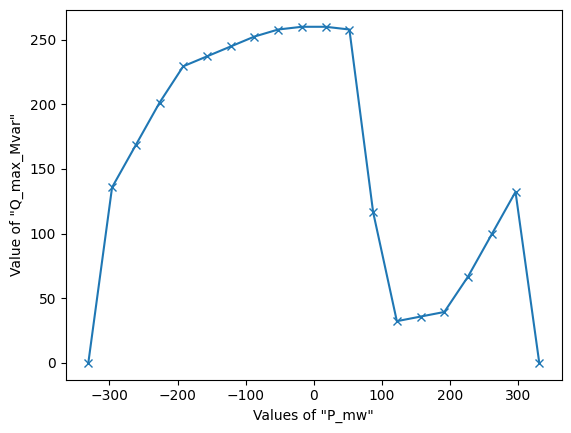

In [12]:
pp.control.plot_characteristic(
    net3.q_capability_characteristic.q_max_characteristic.at[0],
    -331,
    331,
    xlabel='Values of "P_mw"',
    ylabel='Value of "Q_max_Mvar"',
)

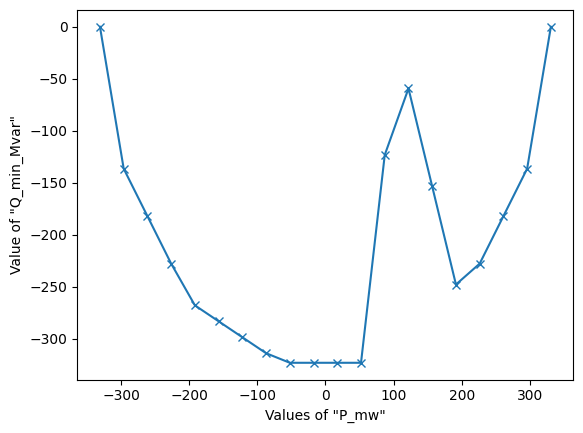

In [13]:
pp.control.plot_characteristic(
    net3.q_capability_characteristic.q_min_characteristic.at[0],
    -331,
    331,
    xlabel='Values of "P_mw"',
    ylabel='Value of "Q_min_Mvar"',
)

In [14]:
pp.runpp(net3, enforce_q_lims=True)
assert net3.res_gen.q_mvar.loc[0] == 0
assert net3.res_gen.p_mw.loc[0] == 100

# Validation and Impact on Load Flow
To verify the impact of the adjusted values on the power system simulation:
* Voltage magnitudes at generator buses are examined. <br>
* Reactive power generation is observed to remain constant when the generator reaches its defined limits during load flow analysis.
* A comparative analysis is performed to evaluate the difference in results across three cases:
    * No reactive power limit applied <br>
    * General reactive power limits enforced<br>
    * Limits derived from the characteristic table

In [15]:
print("\n --------No reactive power limit applied-----------------\n")
print(f"Qmin={net1.gen.min_q_mvar.loc[0]}")
print(f"QMax={net1.gen.max_q_mvar.loc[0]}\n")
print(net1.res_gen)
print(net1.res_bus)
print("\n --------General reactive power limits enforced-------------\n")
print(f"Qmin={net2.gen.min_q_mvar.loc[0]}")
print(f"QMax={net2.gen.max_q_mvar.loc[0]}\n")
print(net2.res_gen)
print(net2.res_bus)
print("\n --------Limits derived from the characteristic table---------\n")
print(f"Qmin={net3.gen.min_q_mvar.loc[0]}")
print(f"QMax={net3.gen.max_q_mvar.loc[0]}\n")
print(net3.res_gen)
print(net3.res_bus)


 --------No reactive power limit applied-----------------

Qmin=nan
QMax=nan

    p_mw    q_mvar  va_degree  vm_pu
0  100.0 -3.767667  35.237286    1.0
      vm_pu  va_degree        p_mw     q_mvar
0  1.000000  35.237286 -100.000000   3.767667
1  1.004081   1.838210    0.000000   0.000000
2  1.000000   0.000000   99.204901 -13.425442

 --------General reactive power limits enforced-------------

Qmin=-3.0
QMax=50.0

    p_mw  q_mvar  va_degree     vm_pu
0  100.0    -3.0  35.230084  1.000706
      vm_pu  va_degree      p_mw     q_mvar
0  1.000706  35.230084 -100.0000   3.000000
1  1.004326   1.834276    0.0000   0.000000
2  1.000000   0.000000   99.2065 -12.640224

 --------Limits derived from the characteristic table---------

Qmin=nan
QMax=nan

    p_mw  q_mvar  va_degree     vm_pu
0  100.0     0.0  35.202086  1.003454
      vm_pu  va_degree        p_mw  q_mvar
0  1.003454  35.202086 -100.000000  0.0000
1  1.005278   1.818956    0.000000  0.0000
2  1.000000   0.000000   99.211806 -9.

The results confirm that applying the reactive power capability characteristics leads to distinct voltage profiles and a controlled reactive power response, significantly influencing the overall power system behavior.

# Diagnostic
The
diagnostic
function
for generator reactive power characteristics checks the following:

* Are there Q capability curve characteristic table?
* Are there ** reactive_capability_curve **, ** curve_style ** and ** id_q_capability_characteristic ** missing in net.gen or net.sgen?
*Check if all
relevant
columns
for creating Q capability characteristics are populated in the ** q_capability_curve_table **
*Check
the
data
types
of ** reactive_capability_curve ** and ** id_q_capability_characteristic **
* Are there any missing ** id_q_capability_characteristic ** values in the ** q_capability_curve_table ** ?

The
results
are
displayed
to
the
user
with the help of warning statements.

In [16]:
net4 = test_net_for_q_capability_curve(characteristics_data=True)
create_q_capability_characteristics_object(net4)
q_capability_curve_table_diagnostic(net4, "gen")
# pp.runpp(net4, enforce_q_lims=True)

True

In [17]:
net4.gen.loc[0, "reactive_capability_curve"] = False
q_capability_curve_table_diagnostic(net4, "gen")

C:\Users\gjmal\PycharmProjects\pandapower-develop\pandapower\pandapower\control\util\diagnostic.py:230: UserWarning: Found 1 gen(s) with mismatched between curve_style, reactive_capability_curve and id_q_capability_curve_characteristic parameters populated. Power flow calculation will raise an error.
  warnings.warn(f"Found {mismatch} {element}(s) with mismatched between curve_style, "


False

In [18]:
net4 = test_net_for_q_capability_curve(characteristics_data=True)
create_q_capability_characteristics_object(net4)
net4.gen.loc[0, "reactive_capability_curve"] = False
net4.gen.loc[0, "id_q_capability_characteristic"] = np.nan
q_capability_curve_table_diagnostic(net4, "gen")

C:\Users\gjmal\PycharmProjects\pandapower-develop\pandapower\pandapower\control\util\diagnostic.py:230: UserWarning: Found 1 gen(s) with mismatched between curve_style, reactive_capability_curve and id_q_capability_curve_characteristic parameters populated. Power flow calculation will raise an error.
  warnings.warn(f"Found {mismatch} {element}(s) with mismatched between curve_style, "
C:\Users\gjmal\PycharmProjects\pandapower-develop\pandapower\pandapower\control\util\diagnostic.py:269: UserWarning: Not all id_q_capability_curve_characteristic values of gen are present in the q_capability_curve_table.
  warnings.warn(f"Not all id_q_capability_curve_characteristic values of {element} are present in the "


False

In [19]:
net4 = test_net_for_q_capability_curve(characteristics_data=True)
create_q_capability_characteristics_object(net4)
net4.gen.loc[0, "curve_style"] = "hi"
net4.q_capability_curve_table.drop(columns="q_min_mvar")
q_capability_curve_table_diagnostic(net4, "gen")

C:\Users\gjmal\PycharmProjects\pandapower-develop\pandapower\pandapower\control\util\diagnostic.py:261: UserWarning: There are 1 unknown curve style in curve_style column of the gen table
  warnings.warn(f"There are {curve_df.count()} unknown curve style in curve_style column of the "


False

In [20]:
net4 = test_net_for_q_capability_curve(characteristics_data=True)
create_q_capability_characteristics_object(net4)
net4.q_capability_curve_table.q_min_mvar = np.nan
net4.q_capability_curve_table.drop(columns="q_min_mvar")
q_capability_curve_table_diagnostic(net4, "gen")

C:\Users\gjmal\PycharmProjects\pandapower-develop\pandapower\pandapower\control\util\diagnostic.py:242: UserWarning: There are some gen(s) with not all characteristics populated in the q_capability_curve_table.
  warnings.warn(f"There are some {element}(s) with not all characteristics "


False